[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Фильтрация и очистка сообщений

## Итоги предыдущего раздела

Теперь мы глубже понимаем несколько аспектов:

* Как настраивать схему состояния графа
* Как определять пользовательские редьюсеры состояния
* Как использовать множественные схемы состояния графа

## Цели текущего раздела

Теперь мы можем начать применять эти концепции с моделями в LangGraph!

В следующих нескольких занятиях мы создадим чат-бота с долговременной памятью.

Поскольку наш чат-бот будет использовать сообщения, давайте сначала подробнее рассмотрим продвинутые способы работы с сообщениями в состоянии графа.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_mistralai

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("MISTRAL_API_KEY")

MISTRAL_API_KEY:  ········


Мы будем использовать [LangSmith](https://docs.langchain.com/langsmith/home) для [трассировки](https://docs.langchain.com/langsmith/observability-concepts).

Логи будут записываться в проект `langchain-academy`.

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"
os.environ["LANGSMITH_ENDPOINT"] = "https://eu.api.smith.langchain.com"

LANGSMITH_API_KEY:  ········


## Сообщения как состояние

Сначала давайте определим несколько сообщений.

In [35]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Вспомним, что мы можем передать их в чат-модель.

In [36]:
from langchain_mistralai import ChatMistralAI
llm = ChatMistralAI(model="mistral-medium-latest")
llm.invoke(messages)

AIMessage(content='Great! The ocean is home to a fascinating diversity of marine mammals beyond whales. Here’s a breakdown of the major groups you should explore, along with some standout species and key topics to research:\n\n---\n\n### **1. Dolphins (Family: Delphinidae)**\n   - **Why they’re interesting**: Highly intelligent, social, and known for complex communication (e.g., signature whistles). Some use tools (e.g., sponge-foraging in bottlenose dolphins).\n   - **Key species**:\n     - **Bottlenose dolphin** (*Tursiops truncatus*) – The "classic" dolphin; stars of research on cognition and echolocation.\n     - **Orca (killer whale)** (*Orcinus orca*) – Technically the largest dolphin! Apex predators with diverse hunting strategies (e.g., wave-washing seals, cooperative hunting).\n     - **Spinner dolphin** (*Stenella longirostris*) – Famous for acrobatic spins.\n     - **Amazon river dolphin** (*Inia geoffrensis*) – Pink, freshwater species with flexible necks (unlike oceanic do

Мы можем запустить нашу чат-модель в простом графе с `MessagesState`.

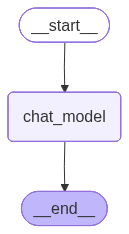

In [37]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Вершина
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Строим граф
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# Смотрим
display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Great! The ocean is home to a fascinating diversity of mammals beyond whales. Here’s a breakdown of the major groups you should explore, along with some standout species and key topics to research:

---

### **1. Cetaceans (Whales, Dolphins, and Porpoises)**
*(You already know whales, but here’s more!)*
- **Dolphins**:
  - **Bottlenose Dolphin** (*Tursiops truncatus*) – Highly intelligent, social, and famous for echolocation.
  - **Orca (Killer Whale)** (*Orcinus orca*) – Apex predators with complex social structures (matrilineal pods).
  - **Amazon River Dolphin** (*Inia geoffrensis*) – Pink freshwater dolphin w

## Редьюсер

Практическая проблема при работе с сообщениями — управление длительными диалогами.

Длительные диалоги приводят к высокому потреблению токенов и задержкам, если мы не будем осторожны, поскольку мы передаём модели постоянно растущий список сообщений.

У нас есть несколько способов решения этой проблемы.

Во-первых, вспомним трюк, который мы видели с использованием `RemoveMessage` и редьюсера `add_messages`.

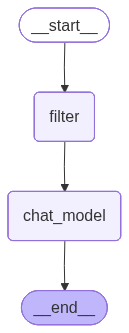

In [41]:
from langchain_core.messages import RemoveMessage

# Вершины
def filter_messages(state: MessagesState):
    # Удаляем все сообщения кроме последних двух
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Строим граф
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# Смотрим
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
# Длинный список сообщений
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Вызываем модель
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Great! Since you're already familiar with whales, here are some other fascinating marine and aquatic topics you might enjoy exploring:

### **1. Marine Mammals (Beyond Whales)**
   - **Dolphins & Porpoises** – Their intelligence, echolocation, and social structures.
   - **Seals & Sea Lions** – Differences between true seals (phocids) and eared seals (otariids).
   - **Manatees & Dugongs** – Gentle herbivores related to el

## Фильтрация сообщений

Если вам не нужно или не хочется изменять состояние графа, вы можете просто отфильтровать сообщения, передаваемые в чат-модель.

Например, просто передайте отфильтрованный список: `llm.invoke(messages[-1:])` в модель.

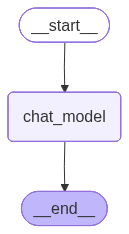

In [21]:
# Вершина
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Строим граф
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# Смотрим
display(Image(graph.get_graph().draw_mermaid_png()))

Давайте возьмём наш существующий список сообщений, добавим к нему ответ LLM и следующий вопрос.

In [22]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [23]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Great! Since you're already familiar with whales, here are some other fascinating marine and aquatic topics you might enjoy exploring:

### **1. Marine Mammals (Beyond Whales)**
   - **Dolphins & Porpoises** – Their intelligence, echolocation, and social structures.
   - **Seals & Sea Lions** – Differences between true seals (phocids) and eared seals (otariids).
   - **Manatees & Dugongs** – Gentle herbivores related to el

In [26]:
# Вызываем модель с использованием фильтрации сообщений
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Great! Since you're already familiar with whales, here are some other fascinating marine and aquatic topics you might enjoy exploring:

### **1. Marine Mammals (Beyond Whales)**
   - **Dolphins & Porpoises** – Their intelligence, echolocation, and social structures.
   - **Seals & Sea Lions** – Differences between true seals (phocids) and eared seals (otariids).
   - **Manatees & Dugongs** – Gentle herbivores related to el

Состояние содержит все сообщения.

Но давайте посмотрим на трассировку в LangSmith, чтобы убедиться, что вызов модели использует только последнее сообщение: https://eu.smith.langchain.com/


## Очистка сообщений

Другой подход — [очистка сообщений](https://docs.langchain.com/oss/python/langgraph/add-memory#trim-messages) на основе заданного количества токенов.

Это ограничивает историю сообщений указанным количеством токенов.

В то время как фильтрация только возвращает постфактум подмножество сообщений между агентами, очистка ограничивает количество токенов, которые чат-модель может использовать для ответа.

Смотрите `trim_messages` ниже.

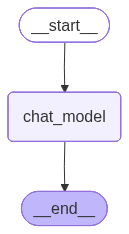

In [27]:
from langchain_core.messages import trim_messages

# Вершина
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatMistralAI(model="mistral-medium-latest"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Строим граф
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# Смотрим
display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [29]:
# Пример обрезки сообщений
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatMistralAI(model="mistral-medium-latest"),
            allow_partial=False
        )

Token indices sequence length is longer than the specified maximum sequence length for this model (2192 > 1024). Running this sequence through the model will result in indexing errors


[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [34]:
# Вызываем модель с обрезкой длины сообщений
messages_out_trim = graph.invoke({'messages': messages})

Давайте посмотрим на трассировку в LangSmith, чтобы увидеть вызов модели: https://eu.smith.langchain.com/